In [1]:
%matplotlib inline

In [380]:
import itertools as it

import numpy as np
import scipy as sp
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import GPy

Read in data, then convert the second level (i.e. index=1) from strings to floats.  This conversion ensures that columns are recognised as "sorted" and `.loc` slicing works as expected.

In [4]:
inp = pd.read_csv("csi/testdata/Demo_DREAM.csv",index_col=0,header=[0,1])

inp.columns = pd.MultiIndex.from_tuples(
    inp.columns.set_levels(level=1,
        levels=np.array(inp.columns.levels[1],dtype=float)),
    names=inp.columns.names)

In [5]:
inp.loc["Gene1",("T1",pd.IndexSlice[0:500])]

Treatment  Time
T1         0       0.709247
           50      0.227989
           100     0.080199
           150     0.007677
           200     0.004652
           250     0.003049
           300     0.000790
           350     0.000000
           400     0.002035
           450     0.002429
           500     0.005413
Name: Gene1, dtype: float64

I define `inpX` to be the inputs to the GP regressions and `inpY` the outputs.  Given time series upto $t$, `inpX` therefore contains indicies $1\dots t-1$ and `inpY` indicies $2\dots t$, i.e. both contain one less element than `inp`.

This is all somewhat complicated by the fact that we have replicates, I currently don't want to assume that every replicate has the same number of time points.  However, given the requirement that the time points are "evenly" spaced kind of implies that each replicate will always have exactly the same time points associated.

In [6]:
def getIndicies(x):
    """Returns indicies, [i], where item $x_i = x_{i-1}$."""
    prev = None
    for i, a in enumerate(x):
        if a == prev:
            yield i
        prev = a

ix = np.array(list(getIndicies([a for a,b in iter(inp.columns)])))
inpX = inp.iloc[slice(None),ix-1].T
inpY = inp.iloc[slice(None),ix].T

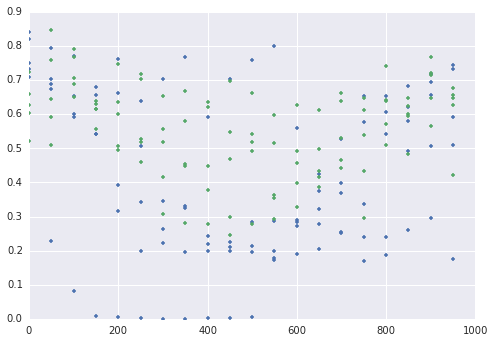

In [381]:
plt.plot([b for a,b in inpX.index],
         inpX[["Gene1","Gene2"]],'.');

GP_regression.,Value,Constraint,Prior,Tied to
rbf.variance,0.172819304254,+ve,,
rbf.lengthscale,0.248134803077,+ve,,
Gaussian_noise.variance,0.0295289601331,+ve,,


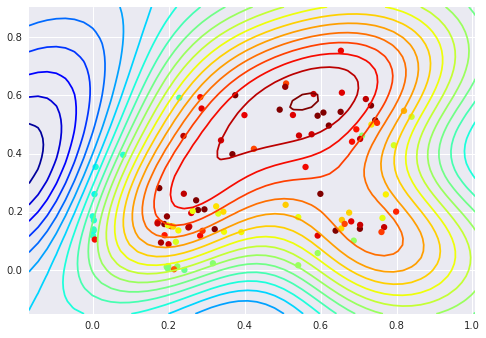

In [383]:
m = GPy.models.GPRegression(inpX[["Gene1","Gene8"]],inpY[["Gene10"]])
m.optimize()
m.plot();
m

In [9]:
def setup(itX, Y):
    for i in itX:
        yield GPy.models.GPRegression(inpX[list(i)],Y)

def optimise(it):
    for m in it:
        m.optimize()

In [399]:
def runOpt(weights, theta):
    def fn(theta):
        ll = 0.
        grad = np.zeros(len(theta))
        wmx = max(weights)
        for i in np.argsort(-weights):
            # weights are expected to be highly correlated with expected log-likelihood, no point evaluating 
            if weights[i] < wmx * 1e-6:
                continue
            m = M[i]
            # m.optimizer_array = np.log(theta)
            m[''] = theta
            ll   += weights[i] * m.log_likelihood()
            grad += weights[i] * m.gradient
        return -ll, -grad
    return sp.optimize.minimize(fn, theta, jac=True,
                                bounds=[(1e-8,None)]*len(theta))

def logLikUnweighted(theta):
    ll = np.zeros(len(M))
    for i,m in enumerate(M):
        m[''] = theta
        ll[i] = m.log_likelihood()
    return ll

def calcWeights(ll):
    w = np.exp(ll - max(ll))
    return w / np.sum(w)

    nfev: 100
 success: True
     jac: array([ -5.41827477e-05,   3.27417115e-05,   3.65974427e-05])
       x: array([ 0.19662772,  0.46036277,  0.04396993])
     fun: -3.1593704669169673
 message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nit: 54
  status: 0
CPU times: user 40 s, sys: 3.27 s, total: 43.3 s
Wall time: 41.4 s


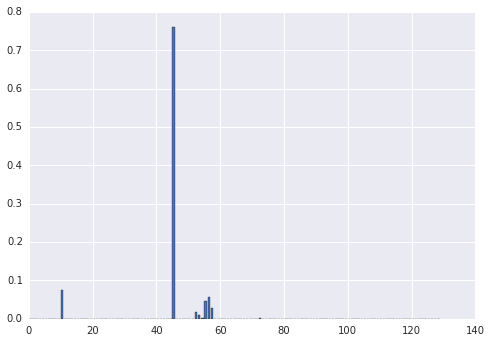

In [400]:
%%time
itl = np.delete(inp.index,9)
p = list(it.chain(it.combinations(itl,1),
                  it.combinations(itl,2),
                  it.combinations(itl,3)
                 ))

M = list(setup(iter(p), inpY[["Gene10"]]))

weights = np.ones(len(p)) / len(p)
res = runOpt(weights, np.exp(sp.randn(3)*5))
print(res)

ll = logLikUnweighted(res.x)
weights = calcWeights(ll)
plt.bar(range(len(weights)),weights);

[ 0.1336606   0.34824638  0.02475406]
CPU times: user 733 ms, sys: 45.3 ms, total: 778 ms
Wall time: 754 ms


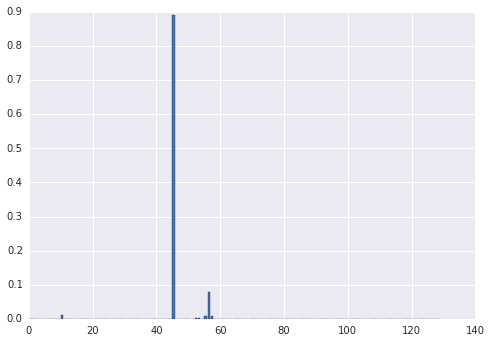

In [405]:
%%time
res = runOpt(weights, res.x)
print(res.x)

ll = logLikUnweighted(res.x)
weights = calcWeights(ll)
plt.bar(range(len(weights)),weights);

In [394]:
for i in np.argsort(-ll):
    print("%3i: %6.2f = %s" % (i, ll[i],",".join(p[i])))

 45:  26.15 = Gene1,Gene2,Gene3
 56:  23.73 = Gene1,Gene3,Gene8
 10:  21.75 = Gene1,Gene3
 57:  21.58 = Gene1,Gene3,Gene9
 55:  21.51 = Gene1,Gene3,Gene7
 52:  19.69 = Gene1,Gene3,Gene4
 53:  19.58 = Gene1,Gene3,Gene5
 72:  16.95 = Gene1,Gene8,Gene9
 54:  16.42 = Gene1,Gene3,Gene6
 68:  14.85 = Gene1,Gene6,Gene8
 61:  14.21 = Gene1,Gene4,Gene8
 50:  13.71 = Gene1,Gene2,Gene8
120:  13.70 = Gene5,Gene6,Gene8
 64:  12.26 = Gene1,Gene5,Gene7
 65:  12.24 = Gene1,Gene5,Gene8
 74:  12.09 = Gene2,Gene3,Gene5
 63:  12.04 = Gene1,Gene5,Gene6
 60:  11.83 = Gene1,Gene4,Gene7
 15:  10.69 = Gene1,Gene8
 62:  10.54 = Gene1,Gene4,Gene9
 70:  10.30 = Gene1,Gene7,Gene8
100:   9.62 = Gene3,Gene5,Gene7
119:   9.55 = Gene5,Gene6,Gene7
 71:   9.49 = Gene1,Gene7,Gene9
 49:   9.31 = Gene1,Gene2,Gene7
 66:   9.05 = Gene1,Gene5,Gene9
 46:   8.75 = Gene1,Gene2,Gene4
 99:   8.63 = Gene3,Gene5,Gene6
 14:   7.14 = Gene1,Gene7
122:   6.70 = Gene5,Gene7,Gene8
 51:   6.20 = Gene1,Gene2,Gene9
 85:   6.19 = Gene2,Gene5,

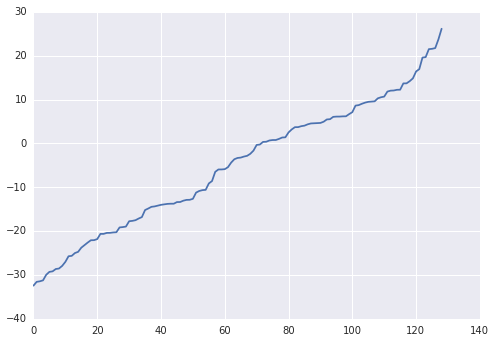

In [389]:
plt.plot(np.sort(ll));